# Asses the Impact of Variation of the Generation on the Power Flow Results

### Create the Network

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('..')
from thesis_package import utils, extractor as ex, elements as el, powerflow as pf, metrics as my_metrics, aimodels as my_ai
# RMSE
from sklearn.metrics import mean_squared_error

In [10]:
if 'network.pickle' not in os.listdir('..'):
    # Create a network from the data.
    network = el.Network()
    network.create_network_from_xlsx(xlsx_file_path="\data\\raw\\Data_Example_32.xlsx")
    # Create the pandapower network.
    network.create_pandapower_model() # Property name: net_model.
    # Plot the network.
    network.plot_network()
    # Method that receives the .csv files folder and adds the gen profile to the grid elements.
    network.add_generation_profiles(generation_profiles_folder_path='.\data\processed\production')
    # Method that receives a .csv files folder and adds the load profile to the grid elements.
    network.add_load_profiles(load_profiles_folder_path='.\data\processed\consumption')
    # Power flow calculation
    utils.serialize_object('network', network, message='Serializing network object...')
else:
    network = utils.deserialize_object('../network', message='Deserializing network...')

Deserializing ../network... Please wait
Deserializing network...🗸 (Execution time: 0.024997[s])


### Run the Power Flow Calculation with Different Variations on the Generation Values

In [11]:
def run_gen_error_experiement(gen_error):
    power_flow = pf.Power_Flow()
    path_to_results_folder = '..\data\paper\gen_error_experiment\gen_error_{}'.format(gen_error)
    try: 
        os.listdir(path_to_results_folder)
    except: 
        os.makedirs(path_to_results_folder)
    power_flow.run_timeseries_power_flow(network, path_to_results_folder=path_to_results_folder,\
                                        gen_error=gen_error)
run_gen_error_experiement(0.7)
run_gen_error_experiement(0.8)
run_gen_error_experiement(0.9)
run_gen_error_experiement(1.1)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete



In [17]:
run_gen_error_experiement(1.0)

Progress: |██████████████████████████████████████████████████| 100.0% Complete



### Compute the RMSE of the PF Results w.r to the Ground Truth

The bus examined is the bus 16.

In [19]:
pf_results_07 = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_0.7\pf_res_bus_vm_pu.csv')
pf_results_08 = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_0.8\pf_res_bus_vm_pu.csv')
pf_results_09 = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_0.9\pf_res_bus_vm_pu.csv')
pf_results_11 = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_1.1\pf_res_bus_vm_pu.csv')
pf_results_ref = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_1.0\pf_res_bus_vm_pu.csv')

In [23]:
result_rmse = pd.DataFrame(index=["rmse"], columns=["0.7", "0.8", "0.9", "1.1"])
for i, pf_result in enumerate([pf_results_07, pf_results_08, pf_results_09, pf_results_11]):
    result_rmse.iloc[0, i] = mean_squared_error(pf_results_ref['bus_16'], pf_result['bus_16'],  squared=False)
result_rmse

,0.7,0.8,0.9,1.1
rmse,0.014602,0.009643,0.004777,0.004692


## Compute the Difference in the Number of Constraints w.r to the Ground Truth

In [31]:
def get_boolean_datasets(path_to_pf_res):
    res_bus_vm_pu = pd.read_csv(path_to_pf_res)
    res_bus_vm_pu.drop('timestamps', axis=1, inplace=True) 
    # Max bus_vm_pu constraint
    res_bus_vm_pu_max_constr = res_bus_vm_pu.apply(lambda x: (x - 1.05).apply(lambda y: max(0, y)))
    # Min bus_vm_pu constraint
    res_bus_vm_pu_min_constr = res_bus_vm_pu.apply(lambda x: (0.95 - x).apply(lambda y: max(0, y)))
    # Compute thresholds
    max_u_threshold = utils.compute_threshold(res_bus_vm_pu_max_constr)
    min_u_threshold = utils.compute_threshold(res_bus_vm_pu_min_constr)
    turn_boolean = lambda df, threshold: df.apply(lambda x: x.apply(lambda y: 1 if y > threshold else 0))
    # Create boolean data sets
    res_bus_vm_pu_max_bool_constr = turn_boolean(res_bus_vm_pu_max_constr, utils.compute_threshold(res_bus_vm_pu_max_constr))
    res_bus_vm_pu_min_bool_constr = turn_boolean(res_bus_vm_pu_min_constr, utils.compute_threshold(res_bus_vm_pu_min_constr))
    return res_bus_vm_pu_max_bool_constr, res_bus_vm_pu_min_bool_constr
for error_value in [0.7, 0.8, 0.9, 1.0, 1.1]:
    max_u_bool_df, min_u_bool_df = get_boolean_datasets('..\data\paper\gen_error_experiment\gen_error_{}\pf_res_bus_vm_pu.csv'\
                                                        .format(error_value))
    max_u_bool_df.to_csv('..\data\paper\gen_error_experiment\gen_error_{}\\bool_df_max_u.csv'\
                        .format(error_value), index=False)
    min_u_bool_df.to_csv('..\data\paper\gen_error_experiment\gen_error_{}\\bool_df_min_u.csv'\
                        .format(error_value), index=False)

<AxesSubplot:>

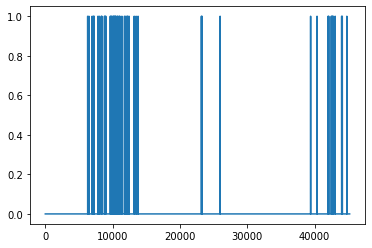

In [42]:
max_u_bool_07 = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_0.8\\bool_df_max_u.csv')
max_u_bool_07['bus_16']

In [61]:
result_num_constr = pd.DataFrame(index=["max_u", "min_u"], columns=["0.7", "0.8", "0.9", "1.0", "1.1"])
for error in result_num_constr.columns:
    max_u_bool = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_{}\\bool_df_max_u.csv'\
        .format(error))
    result_num_constr.loc['max_u'][error] = max_u_bool['bus_16'][max_u_bool['bus_16'] == 1].count()
    min_u_bool = pd.read_csv('..\data\paper\gen_error_experiment\gen_error_{}\\bool_df_min_u.csv'\
        .format(error))
    result_num_constr.loc['min_u'][error] = min_u_bool['bus_16'][min_u_bool['bus_16'] == 1].count()
result_num_constr

,0.7,0.8,0.9,1.0,1.1
max_u,0,169,1317,3356,5374
min_u,7487,7212,6969,6773,6579
